In [1]:
#Importing Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [3]:
#parameter values
Kcam = 0.055 #um, Equilibrium dissociation constant of CCaMK3Ca2+(CaM4Ca2+) complex
K_dotcam = 0.005 #um, Equilibrium dissociation constant of CCaMKP3Ca2+(CaM4Ca2+) complex
k_star_off = 0.1 #-s, Dissociation rate constant of CaM for CCaMK3Ca2+ at basal Ca2+ level
k_off = 0.0001 #-s, Dissociation rate constant of CaM for CCaMK3Ca2+ at Ca2+ spiking amplitude
k_on = 0.00182 #um-1 s-1, Association rate constant of CaM for CCaMK3Ca2+ ( koff /KCaM) at Ca2+ spiking  amplitude
k_pstar_off = 0.1 # -s, Dissociation rate constant of CaM for CCaMKP3Ca2+ at basal Ca2+ level
k_p_off = 0.0001 #s-1, Dissociation rate constant of CaM for CCaMKP3Ca2+ at Ca2+ spiking amplitude
k_p_on = 0.0182 #um-1 s-1,Association rate constant of CaM for CCaMKP3Ca2+ ( koff  p /K'CaM) at Ca2+  spiking amplitude
Kck1 = 0.200 #um, Dissociation constant of CCaMK EF-hand 1 for Ca2+
Kck2 = 0.200 #um, Dissociation constant of CCaMK EF-hand 2 for Ca2+
Kck3 = 0.020 #um, Dissociation constant of CCaMK EF-hand 3 for Ca2+
Kcam1 = 15 #um, Dissociation constant for N-terminal CaM EF-hands for Ca2+
Kcam2 = 1 #um, Dissociation constant for NC-terminal CaM EF-hands for Ca2+
k1 = 0.0015 #uM-1s-1,rate constant for CCaMK autophosphorylation with Ca2+-saturated CCaMK  as kinase
k2 = 0.7250 #uM-1s-1,rate constant for CCaMK autophosphorylation with Ca2+-saturated Thr-271  phosphorylated CCaMK as kinase
k_dp = 0.001 #s-1, CCaMK dephosphorylation rate
k_cdp = 0.001 # s-1, CCaMK dephosphorylation rate in presence of CaM
C = 10 #um, Total CaM concentration
T = 0.1 #um, Total CCaMK concentration; however, assay conc used is 0.3uM
k_cy_p = 0.15 #um -1, s-1,Target substrate phosphorylation rate
k_cy_dp = 0.001 #s-1, Target substrate dephosphorylation rate
ac = 0.01 # Kinase activity factor
x0 = 0.014 #uM, initial x1 value at time = 0

sign_int = 100 #s, Time Period and amplitude of the sinosoidal Ca2+ signal
amplitude = 0.7 #um, Time Period and amplitude of the sinosoidal Ca2+ signal
basal_Ca = 0.15 #um, Basal Ca2+ concentration; however, assay conc used is 0.1mM

#setting pre-requisite functions

#Pck = probability of CCaMK EF hands being saturated.
#Unsaturated CCaMK given by 1 - Pck
def Pck_eq(c_conc = basal_Ca):
    return (c_conc/(Kck1+c_conc))*(c_conc/(Kck2+c_conc))*(c_conc/(Kck3+c_conc))
Pck = Pck_eq()

def Pcam_eq(c_conc = basal_Ca):
    return (c_conc/(Kcam1+c_conc))*(c_conc/(Kcam2+c_conc))
Pcam = Pcam_eq()

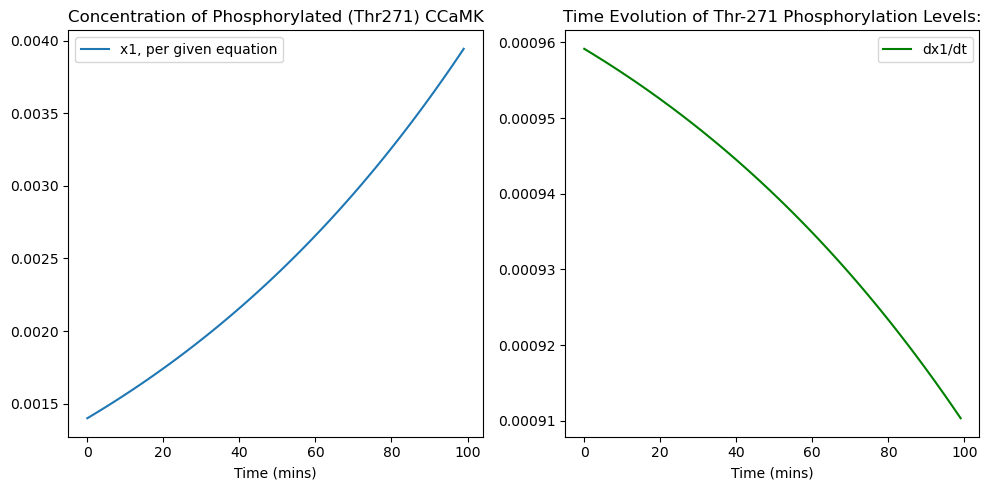

In [42]:
#testing function and derivative provided by the paper for x1, phosphorylated CCaMK across time

time = np.linspace(0,99,100)

def x1_eq(x0,t):
    A = (1-x0)/(k1-x0*(k1-k2))
    return (T*(1-A*k1*np.exp(-k2*Pck*(1-Pck)*T*t)))/(1-(k1-k2)*A*np.exp(-k2*Pck*(1-Pck)*T*t))

def dx1_eq(x0,t):
    A = (1-x0)/(k1-x0*(k1-k2))
    x1 = (T*(1-A*k1*np.exp(-k2*Pck*(1-Pck)*T*t)))/(1-(k1-k2)*A*np.exp(-k2*Pck*(1-Pck)*T*t))
    return ((k1*(T - x1)**2)+(k2*(T - x1)**2)) * (Pck*(1-Pck)) #so, because this equation is solved analytically to derive x1, I'm going to assume it's not actually meant to be used directly.

x1 = x1_eq(x0,time)
dx1_dt = dx1_eq(x0,time)
der_x1 = odeint(dx1_eq,x0,time)


fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].plot(time,x1, label = 'x1, per given equation')
# ax[0].plot(time,der_x1,label = 'x1 per derived dx1')
ax[0].set_xlabel('Time (mins)')
ax[0].legend (loc = 'best')
ax[0].set_title("Concentration of Phosphorylated (Thr271) CCaMK")

ax[1].plot(time,dx1_dt,'g', label = 'dx1/dt')
ax[1].legend (loc = 'best')
ax[1].set_xlabel('Time (mins)')
ax[1].set_title("Time Evolution of Thr-271 Phosphorylation Levels:")

fig.tight_layout()

Wait okay, so coupled differential equations have to be defined in the same function... that function will have to be huge

In [45]:
#Equations 1 - 4
# x1 = [Phos Thr-271 CCaMK]
# x2 = [CaM-bound CCaMK]
# x3 = [Cam-bound Thr-271]
# x4 = [Phos CCaMK]
# probably a mistake x = [Phos Target Molecule]

a = 1
b = 1
c = 1

def coupled_system(y,t):
    dx1,x1,x2,x3,x4 = y
    dx1 = ((k1*(T - x1)**2)+(k2*(T - x1)**2))*(Pck*(1-Pck))
    dx1_dt = (Pck*(1-Pck)*(k1*(T-x1-x2-x3)**2)) + (k2*x1*(T-x1-x2-x3)) + (k_pstar_off*(1-Pcam)*(1-Pck)*x3) + (k_p_off*Pcam*Pck*x3) - (k_p_on * Pcam * Pck * (C-x2-x3)*x1) - (k_dp*x1)
    dx2_dt = (k_on * Pcam * Pck *(C-x2-x3)*(T-x1-x2-x3)) - (k_star_off * (1-Pcam)*(1-Pck) * x2) - (k_off * Pcam * Pck * x2) + (k_cdp * x3)
    dx3_dt = (k_p_on * Pcam * Pck * (C-x2-x3) * x1) - (k_pstar_off * (1-Pcam)*(1-Pck)*x3) - (k_p_off * Pcam * Pck * x3) - (k_cdp * x3)
    dx4_dt = (k_cy_p * (x2+x3+Pck*ac*(T-x1-x2-x3))*(1-x4)) - (k_cy_dp * x4)
    return [dx1,dx1_dt,dx2_dt,dx3_dt,dx4_dt]

solution = odeint(coupled_system,[x0,x0,a,b,c],time)

print(solution)




[[1.40000000e-02 1.40000000e-02 1.00000000e+00 1.00000000e+00
  1.00000000e+00]
 [1.44255772e-02 4.80720165e-02 9.20634414e-01 9.18802406e-01
  9.99129517e-01]
 [1.46431900e-02 5.62933562e-02 8.47565912e-01 8.44198502e-01
  9.98452366e-01]
 [1.48204925e-02 5.84823983e-02 7.80295053e-01 7.75652498e-01
  9.97898684e-01]
 [1.49873788e-02 5.91413840e-02 7.18361972e-01 7.12672402e-01
  9.97424216e-01]
 [1.51509827e-02 5.93804766e-02 6.61343257e-01 6.54806243e-01
  9.97000230e-01]
 [1.53132488e-02 5.94995105e-02 6.08849072e-01 6.01638766e-01
  9.96607634e-01]
 [1.54747201e-02 5.95870068e-02 5.60520495e-01 5.52788440e-01
  9.96233459e-01]
 [1.56355162e-02 5.96714916e-02 5.16027065e-01 5.07904718e-01
  9.95868708e-01]
 [1.57956158e-02 5.97630573e-02 4.75064529e-01 4.66665513e-01
  9.95507013e-01]
 [1.59549461e-02 5.98657072e-02 4.37352765e-01 4.28774895e-01
  9.95143781e-01]
 [1.61134131e-02 5.99813049e-02 4.02633861e-01 3.93960959e-01
  9.94775645e-01]
 [1.62709127e-02 6.01109093e-02 3.706703

In [46]:
solution_df = pd.DataFrame(solution)
print(solution_df)
solution_df = solution_df.rename(columns={0:'dx1',1:'dx1_dt', 2:'dx2_dt', 3:'dx3_dt', 4:'dx4_dt'})
print(solution_df['dx1'])


           0         1         2         3         4
0   0.014000  0.014000  1.000000  1.000000  1.000000
1   0.014426  0.048072  0.920634  0.918802  0.999130
2   0.014643  0.056293  0.847566  0.844199  0.998452
3   0.014820  0.058482  0.780295  0.775652  0.997899
4   0.014987  0.059141  0.718362  0.712672  0.997424
..       ...       ...       ...       ...       ...
95  0.021120  0.096262  0.000385  0.000363  0.929822
96  0.021121  0.096397  0.000355  0.000337  0.928900
97  0.021123  0.096525  0.000326  0.000313  0.927979
98  0.021124  0.096646  0.000301  0.000291  0.927058
99  0.021125  0.096760  0.000277  0.000271  0.926138

[100 rows x 5 columns]
0     0.014000
1     0.014426
2     0.014643
3     0.014820
4     0.014987
        ...   
95    0.021120
96    0.021121
97    0.021123
98    0.021124
99    0.021125
Name: dx1, Length: 100, dtype: float64


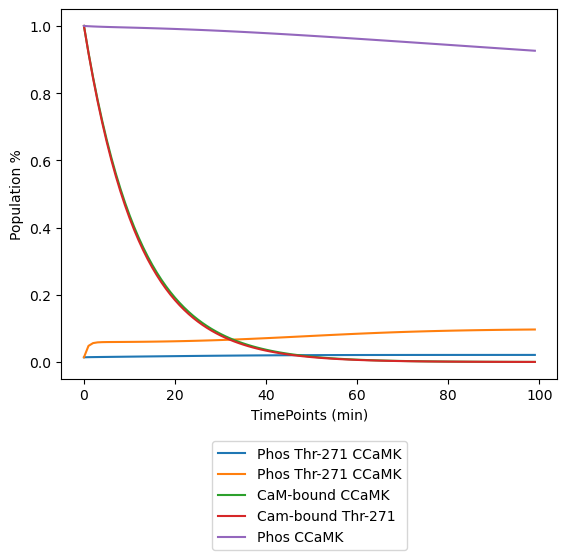

In [47]:
#plotting the solved ODEs
plt.plot(time,solution_df['dx1'], label = 'Phos Thr-271 CCaMK')
plt.plot(time,solution_df['dx1_dt'], label = 'Phos Thr-271 CCaMK')
plt.plot(time,solution_df['dx2_dt'], label = 'CaM-bound CCaMK')
plt.plot(time,solution_df['dx3_dt'], label = 'Cam-bound Thr-271')
plt.plot(time,solution_df['dx4_dt'], label = 'Phos CCaMK')
plt.xlabel('TimePoints (min)')
plt.ylabel('Population %')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          ncol=1, fancybox=True)


# x1 = [Phos Thr-271 CCaMK]
# x2 = [CaM-bound CCaMK]
# x3 = [Cam-bound Thr-271]
# x4 = [Phos CCaMK]
# probably a mistake x = [Phos Target Molecule]

wait, i need to model calcium lol, as a product of time

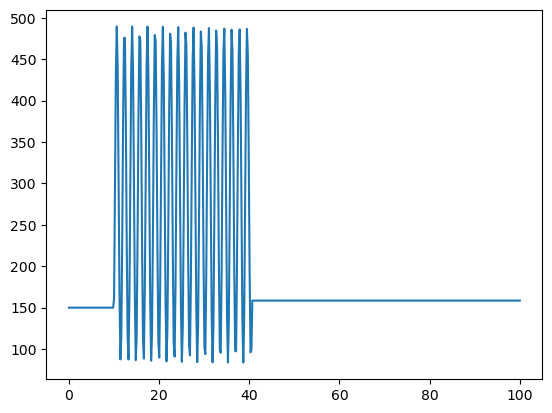

In [77]:
# def c2_conc(c0,t):
#     period = 100
#     freq = (2*np.pi)/(period)
#     amplitude = 0.700 um
#     conc = 270 * np.sin(freq*time) + 420
#     return c2_conc

# def conc_dx(c0,t):
#     if t > 10 and t < 40.615:
#         period = 1.8
#         freq = (2*np.pi)/(period)
#         conc = 750*np.cos(t*freq)
#     else:
#         conc = 0
#     return conc

def conc_dx(c0,t):
    if t > 10 and t < 40.615:
        period = 1.7
        freq = (2*np.pi)/(period)
        conc = 750*np.cos(t*freq)
    else:
        conc = 0
    return conc


time = np.linspace(0,100,500)
plt.plot(time,(odeint(conc_dx, 150, time)))
# plt.title("well, it's not right, but it's derived")

Text(0, 0.5, 'Ca2+ Concentration nM')

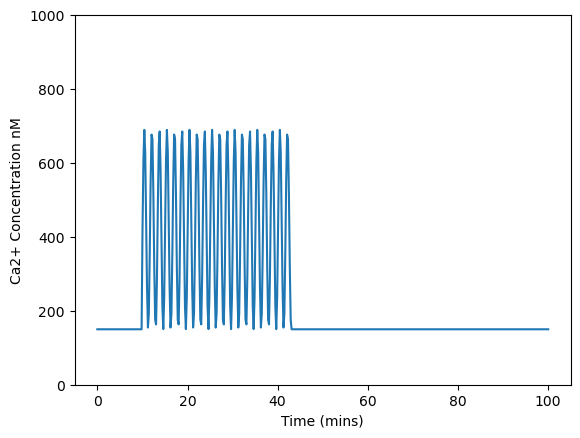

In [56]:
#time period and amplitude for spikes: 100 s, 0.700 μM
# except lol the amplitude clearly isn't 0.700, but infact 0.700 - 0.150.
#frequency = 1/100
#basal ca2+ conc: 0.150 um

def c2_conc(c0,t):
    conc = c0
    if t > 10 and t < 43:
        period = 1.67
        freq = (2*np.pi)/(period)
        conc = 270 * np.sin(freq*t) + 420
    return conc

time = np.linspace(0,100,500)
calcium = []
for n in time:
    moment = c2_conc(150,n)
    calcium.append(moment)
plt.plot(time,calcium)
plt.ylim((0,1000))
plt.xlabel('Time (mins)')
plt.ylabel('Ca2+ Concentration nM')
# plt.title('Calcium Spike...ish')


Text(0, 0.5, 'Ca2+ Concentration nM')

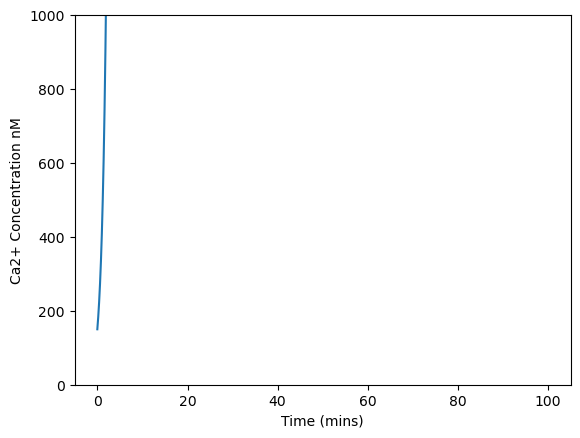

In [60]:
#what does the above look like if i put it through odeint?
test = odeint(c2_conc,150,time)
plt.plot(time,test)
plt.ylim((0,1000))
plt.xlabel('Time (mins)')
plt.ylabel('Ca2+ Concentration nM')
# plt.title("yeah i suppose that'll cause some problems")

and I need to integrate the Pck stuff, etc, into this, since these are dependent on Calcium concentration

In [78]:
#Equations 1 - 4
# x1 = [Phos Thr-271 CCaMK]
# x2 = [CaM-bound CCaMK]
# x3 = [Cam-bound Thr-271]
# x4 = [Phos CCaMK]
# probably a mistake x = [Phos Target Molecule]

#setting pre-requisite functions

#Pck = probability of CCaMK EF hands being saturated.
#Unsaturated CCaMK given by 1 - Pck
def Pck_eq(c_conc = basal_Ca):
    return (c_conc/(Kck1+c_conc))*(c_conc/(Kck2+c_conc))*(c_conc/(Kck3+c_conc))

def Pcam_eq(c_conc = basal_Ca):
    return (c_conc/(Kcam1+c_conc))*(c_conc/(Kcam2+c_conc))


# where equation A_eq holds (sorta) the rate of phosphorylation of unphosphorylated CCaMK at Time = 0?
def A_eq(): 
    return (1-x0)/(k1-x0*(k1-k2))
A = A_eq()

# where x0 is the initial conc of phosphorylated CCaMK
def x1_eq():
    t = 1
    A = A_eq()
    return (T*(1-A*k1*np.exp(-k2*Pck*(1-Pck)*T*t)))/(1-(k1-k2)*A*np.exp(-k2*Pck*(1-Pck)*T*t))
x1 = x1_eq()

def c2_conc_eq(c0,t):
    conc = c0
    if t > 10 and t < 43:
        period = 1.67
        freq = (2*np.pi)/(period)
        conc = 270 * np.sin(freq*t) + 420
    return conc

def coupled_system(y,t):
    c0,x1,x2,x3,x4 = y
    c2_conc = c2_conc_eq(c0,t)
    Pck = Pck_eq(c2_conc)
    Pcam = Pcam_eq(c2_conc)
    dx1_dt = (Pck*(1-Pck)*(k1*(T-x1-x2-x3)**2)) + (k2*x1*(T-x1-x2-x3)) + (k_pstar_off*(1-Pcam)*(1-Pck)*x3) + (k_p_off*Pcam*Pck*x3) - (k_p_on * Pcam * Pck * (C-x2-x3)*x1) - (k_dp*x1)
    dx2_dt = (k_on * Pcam * Pck *(C-x2-x3)*(T-x1-x2-x3)) - (k_star_off * (1-Pcam)*(1-Pck) * x2) - (k_off * Pcam * Pck * x2) + (k_cdp * x3)
    dx3_dt = (k_p_on * Pcam * Pck * (C-x2-x3) * x1) - (k_pstar_off * (1-Pcam)*(1-Pck)*x3) - (k_p_off * Pcam * Pck * x3) - (k_cdp * x3)
    dx4_dt = (k_cy_p * (x2+x3+Pck*ac*(T-x1-x2-x3))*(1-x4)) - (k_cy_dp * x4)
    return [Pck,Pcam,c2_conc]#,dx1_dt,dx2_dt,dx3_dt,dx4_dt]

y0 = [150,0.014,0.0,0.0,0.0] #initial values for x1,x2,x3,x4
# solution = odeint(coupled_system,y0,time)

print(solution)


[[1.40000000e-02 1.40000000e-02 1.00000000e+00 1.00000000e+00
  1.00000000e+00]
 [1.44255772e-02 4.80720165e-02 9.20634414e-01 9.18802406e-01
  9.99129517e-01]
 [1.46431900e-02 5.62933562e-02 8.47565912e-01 8.44198502e-01
  9.98452366e-01]
 [1.48204925e-02 5.84823983e-02 7.80295053e-01 7.75652498e-01
  9.97898684e-01]
 [1.49873788e-02 5.91413840e-02 7.18361972e-01 7.12672402e-01
  9.97424216e-01]
 [1.51509827e-02 5.93804766e-02 6.61343257e-01 6.54806243e-01
  9.97000230e-01]
 [1.53132488e-02 5.94995105e-02 6.08849072e-01 6.01638766e-01
  9.96607634e-01]
 [1.54747201e-02 5.95870068e-02 5.60520495e-01 5.52788440e-01
  9.96233459e-01]
 [1.56355162e-02 5.96714916e-02 5.16027065e-01 5.07904718e-01
  9.95868708e-01]
 [1.57956158e-02 5.97630573e-02 4.75064529e-01 4.66665513e-01
  9.95507013e-01]
 [1.59549461e-02 5.98657072e-02 4.37352765e-01 4.28774895e-01
  9.95143781e-01]
 [1.61134131e-02 5.99813049e-02 4.02633861e-01 3.93960959e-01
  9.94775645e-01]
 [1.62709127e-02 6.01109093e-02 3.706703

[0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371, 0.9972056964414371,

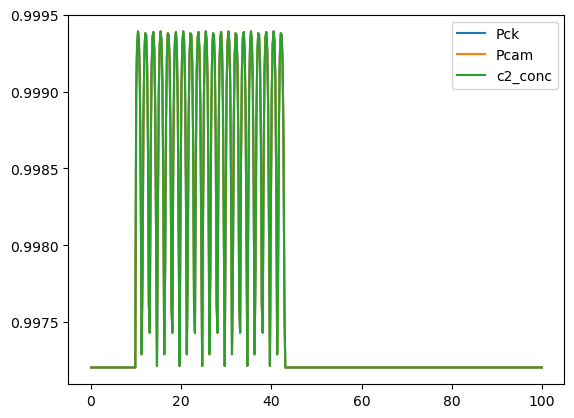

In [91]:

Pck_list=[]
Pcam_list=[]
c2_conc_list=[]
time = np.linspace(0,100,500)

for n in time:
    test = coupled_system(y0,n)
    Pck_list.append(test[0])
    Pcam_list.append(test[0])
    c2_conc_list.append(test[0])

print(Pck_list,Pcam_list,c2_conc_list)

plt.plot(time,Pck_list,label="Pck")
plt.plot(time,Pcam_list,label="Pcam")
plt.plot(time,c2_conc_list,label="c2_conc")
plt.legend(loc="best")

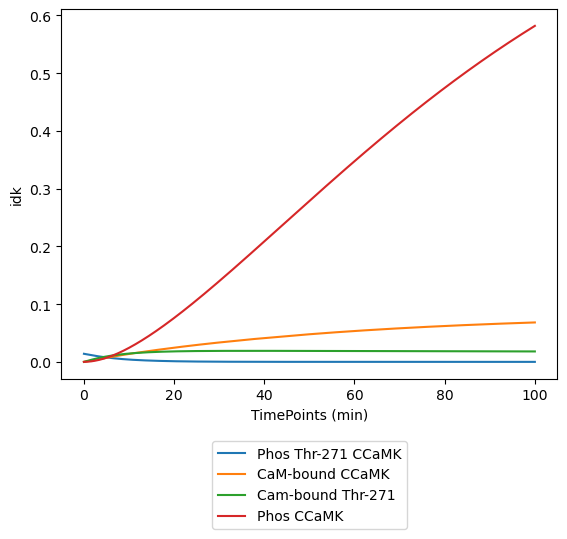

In [100]:
def coupled_system2(y,t):
    c0,x1,x2,x3,x4 = y
    c2_conc = c2_conc_eq(c0,t)
    Pck = Pck_eq(c2_conc)
    Pcam = Pcam_eq(c2_conc)
    dx1_dt = (Pck*(1-Pck)*(k1*(T-x1-x2-x3)**2)) + (k2*x1*(T-x1-x2-x3)) + (k_pstar_off*(1-Pcam)*(1-Pck)*x3) + (k_p_off*Pcam*Pck*x3) - (k_p_on * Pcam * Pck * (C-x2-x3)*x1) - (k_dp*x1)
    dx2_dt = (k_on * Pcam * Pck *(C-x2-x3)*(T-x1-x2-x3)) - (k_star_off * (1-Pcam)*(1-Pck) * x2) - (k_off * Pcam * Pck * x2) + (k_cdp * x3)
    dx3_dt = (k_p_on * Pcam * Pck * (C-x2-x3) * x1) - (k_pstar_off * (1-Pcam)*(1-Pck)*x3) - (k_p_off * Pcam * Pck * x3) - (k_cdp * x3)
    dx4_dt = (k_cy_p * (x2+x3+Pck*ac*(T-x1-x2-x3))*(1-x4)) - (k_cy_dp * x4)
    return [c2_conc,dx1_dt,dx2_dt,dx3_dt,dx4_dt] #Pck,Pcam,

time = np.linspace(0,100,500)
solution = odeint(coupled_system2,y0,time)

solution_df = pd.DataFrame(solution)
solution_df = solution_df.rename(columns={0:'c2_conc',1:'x1', 2:'x2', 3:'x3', 4:'x4'})


# plt.plot(time,calcium, label = 'Calcium Concentration')
plt.plot(time,solution_df['x1'], label = 'Phos Thr-271 CCaMK')
plt.plot(time,solution_df['x2'], label = 'CaM-bound CCaMK')
plt.plot(time,solution_df['x3'], label = 'Cam-bound Thr-271')
plt.plot(time,solution_df['x4'], label = 'Phos CCaMK')
plt.xlabel('TimePoints (min)')
plt.ylabel('idk')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          ncol=1, fancybox=True)
# plt.title("well, that's not meant to happen")

i think the problem is that calcium, pck, and pcam act completely differentily once derived, so instead i want to find them seperately and just reference their list position for each time value.

Text(0.5, 1.0, 'shut the front door')

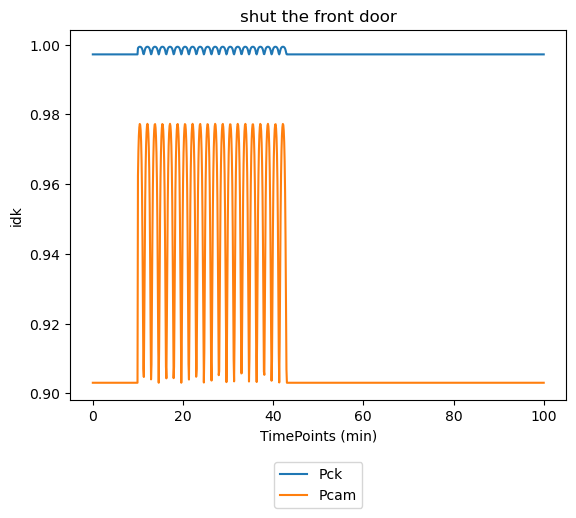

In [632]:
c2_list = []
Pck_list = []
Pcam_list = []

seconds = np.linspace(0,100,1000)

for n in seconds:
    c2_conc = c2_conc_eq(150,n)
    Pck = Pck_eq(c2_conc)
    Pcam = Pcam_eq(c2_conc)
    c2_list.append(c2_conc)
    Pck_list.append(Pck)
    Pcam_list.append(Pcam)

# plt.plot(time,c2_list, label = 'Calcium Concentration')
plt.plot(seconds,Pck_list, label = 'Pck')
plt.plot(seconds,Pcam_list, label = 'Pcam')
plt.xlabel('TimePoints (min)')
plt.ylabel('idk')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          ncol=1, fancybox=True)
plt.title("shut the front door")


In [623]:
#Equations 1 - 4
# x1 = [Phos Thr-271 CCaMK]
# x2 = [CaM-bound CCaMK]
# x3 = [Cam-bound Thr-271]
# x4 = [Phos CCaMK]
# probably a mistake x = [Phos Target Molecule]

#setting pck, pcam, and calcium
timex10 = np.linspace(0,100,1010)

for n in timex10:
    c2_conc = c2_conc_eq(150,n)
    Pck = Pck_eq(c2_conc) #Pck = probability of CCaMK EF hands being saturated.
    Pcam = Pcam_eq(c2_conc)
    c2_list.append(c2_conc)
    Pck_list.append(Pck)
    Pcam_list.append(Pcam)

def coupled_system2(y,t):
    x1,x2,x3,x4 = y
    c2_conc = c2_list[t*10]
    Pck = Pck_list[t*10]
    Pcam = Pcam_list[t*10]
    dx1_dt = (Pck*(1-Pck)*(k1*(T-x1-x2-x3)**2)) + (k2*x1*(T-x1-x2-x3)) + (k_pstar_off*(1-Pcam)*(1-Pck)*x3) + (k_p_off*Pcam*Pck*x3) - (k_p_on * Pcam * Pck * (C-x2-x3)*x1) - (k_dp*x1)
    dx2_dt = (k_on * Pcam * Pck *(C-x2-x3)*(T-x1-x2-x3)) - (k_star_off * (1-Pcam)*(1-Pck) * x2) - (k_off * Pcam * Pck * x2) + (k_cdp * x3)
    dx3_dt = (k_p_on * Pcam * Pck * (C-x2-x3) * x1) - (k_pstar_off * (1-Pcam)*(1-Pck)*x3) - (k_p_off * Pcam * Pck * x3) - (k_cdp * x3)
    dx4_dt = (k_cy_p * (x2+x3+Pck*ac*(T-x1-x2-x3))*(1-x4)) - (k_cy_dp * x4)
    return [Pck,Pcam,c2_conc,dx1_dt,dx2_dt,dx3_dt,dx4_dt]

y0 = [0.014,0.0,0.0,0.0] #initial values for x1,x2,x3,x4
# solution = odeint(coupled_system,y0,time)

time1 = np.linspace(0,100,501)
time1 = time1.astype(int)
time2 = time1.tolist()

Pck_2_list=[]
Pcam_2_list=[]
c2conc_2_list=[]
x1_2_list=[]
x2_2_list=[]
x3_2_list=[]
x4_2_list=[]

for n in time2:
    solution2 = coupled_system2(y0,n)
    Pck_2_list.append(solution2[0])
    Pcam_2_list.append(solution2[1])
    c2conc_2_list.append(solution2[2])
    x1_2_list.append(solution2[3])
    x2_2_list.append(solution2[4])
    x3_2_list.append(solution2[5])
    x4_2_list.append(solution2[6])

# solution_df = pd.DataFrame(solution2)
# solution_df = solution_df.rename(columns={0:'Pck',1:'Pcam', 2:'c2_conc', 3:'x1', 4:'x2',5:'x3',6:'x4'})


Text(0.5, 1.0, 'well... its something?')

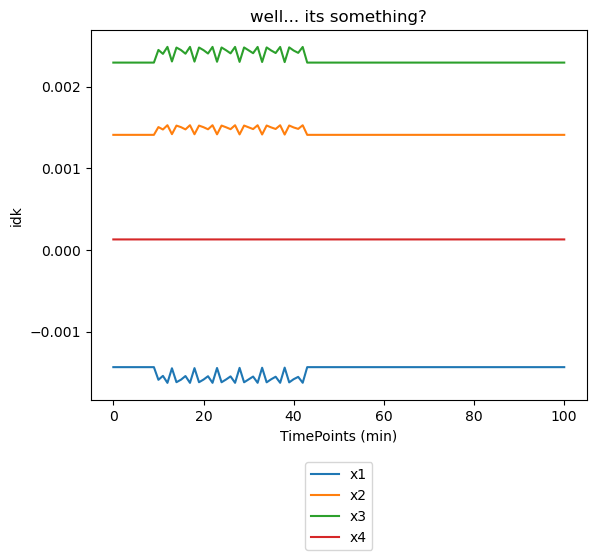

In [625]:
# plt.plot(time2,Pck_2_list, label = 'Pck')
# plt.plot(time2,Pcam_2_list, label = 'Pcam')
# plt.plot(time2,c2conc_2_list, label = 'C2 Conc')
plt.plot(time2,x1_2_list, label = 'x1')
plt.plot(time2,x2_2_list, label = 'x2')
plt.plot(time2,x3_2_list, label = 'x3')
plt.plot(time2,x4_2_list, label = 'x4')
plt.xlabel('TimePoints (min)')
plt.ylabel('idk')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          ncol=1, fancybox=True)
plt.title("well... its something?")

so, the above implies a few problems, but namely: the coupled equations aren't acting as expected, at all. in part because calcium is just on a different scale as is. but also just... everything lol. 
oh wait... this isn't the derivative?

In [640]:
timex10 = np.linspace(0,100,1000)
c2_list = []
Pck_list = []
Pcam_list = []

for n in timex10:
    c2_conc = c2_conc_eq(150,n)
    Pck = Pck_eq(c2_conc)
    Pcam = Pcam_eq(c2_conc)
    c2_list.append(c2_conc)
    Pck_list.append(Pck)
    Pcam_list.append(Pcam)

calcium_dx_dict = {'Time':timex10,'c2_conc':c2_list,'Pck':Pck_list,'Pcam':Pcam_list}
calcium_dx_df = pd.DataFrame(calcium_dx_dict)


100    409.854115
Name: c2_conc, dtype: float64


odeint was complainting about the solution having multiple dimensions; upon investigation, it appears i was storing c2_conc, pck, and pcam within the function as pandas series, and this was carrying down in a problematic fashion. to overcome this, i've used series.iat[]

In [749]:
def coupled_system2(y,t):
    x1,x2,x3,x4 = y
    c2_pd = calcium_dx_df.loc[calcium_dx_df['Time'] == t,'c2_conc']
    c2_conc = c2_pd.iat[0]
    Pck_pd = calcium_dx_df.loc[calcium_dx_df['Time'] == t,'Pck']
    Pck = Pck_pd.iat[0]
    Pcam_pd = calcium_dx_df.loc[calcium_dx_df['Time'] == t,'Pcam']
    Pcam = Pcam_pd.iat[0]
    dx1_dt = (Pck*(1-Pck)*(k1*(T-x1-x2-x3)**2)) + (k2*x1*(T-x1-x2-x3)) + (k_pstar_off*(1-Pcam)*(1-Pck)*x3) + (k_p_off*Pcam*Pck*x3) - (k_p_on * Pcam * Pck * (C-x2-x3)*x1) - (k_dp*x1)
    dx2_dt = (k_on * Pcam * Pck *(C-x2-x3)*(T-x1-x2-x3)) - (k_star_off * (1-Pcam)*(1-Pck) * x2) - (k_off * Pcam * Pck * x2) + (k_cdp * x3)
    dx3_dt = (k_p_on * Pcam * Pck * (C-x2-x3) * x1) - (k_pstar_off * (1-Pcam)*(1-Pck)*x3) - (k_p_off * Pcam * Pck * x3) - (k_cdp * x3)
    dx4_dt = k_cy_p * (x2+x3+Pck*ac*(T-x1-x2-x3))*(1-x4) - (k_cy_dp * x4)
    return [dx1_dt,dx2_dt,dx3_dt,dx4_dt]

Text(0.5, 1.0, 'testing')

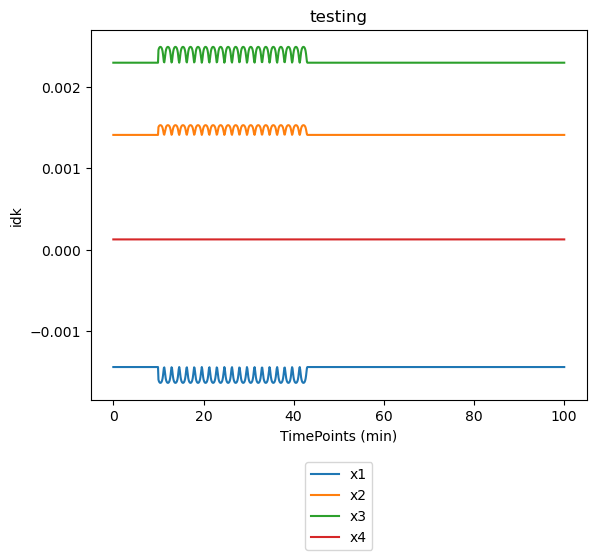

In [774]:
y0 = [0.014,0.0,0.0,0.0]
# c2_list = []
# Pck_list = []
# Pcam_list = []
x1_list=[]
x2_list=[]
x3_list=[]
x4_list=[]

for n in timex10:
    solution2 = coupled_system2(y0,n)
    # Pck_list.append(solution2[0])
    # Pcam_list.append(solution2[1])
    # c2_list.append(solution2[2])
    x1_list.append(solution2[0])
    x2_list.append(solution2[1])
    x3_list.append(solution2[2])
    x4_list.append(solution2[3])

# plt.plot(timex10,Pck_list, label = 'Pck')
# plt.plot(timex10,Pcam_list, label = 'Pcam')
# plt.plot(timex10,c2conc_2_list, label = 'C2 Conc')
plt.plot(timex10,x1_list, label = 'x1')
plt.plot(timex10,x2_list, label = 'x2')
plt.plot(timex10,x3_list, label = 'x3')
plt.plot(timex10,x4_list, label = 'x4')
plt.xlabel('TimePoints (min)')
plt.ylabel('idk')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          ncol=1, fancybox=True)
plt.title("testing")

In [777]:
t = timex10[406]
c2_pd = calcium_dx_df.loc[calcium_dx_df['Time'] == t,'c2_conc']
c2_conc = c2_pd.iat[0]
print(c2_pd)

406    651.782329
Name: c2_conc, dtype: float64


In [780]:
solution = odeint(func = coupled_system2,y0 = y0,t = timex10[1:])

IndexError: index 0 is out of bounds for axis 0 with size 0

well then. odeint dislikes series.at, doesn't it? as much as i liked it. so, i'm going to try create another coupled systems equation, where i just call on the various functions, within the function, to derive c2 conc, pck, and pcam.

In [804]:
def coupled_system3(y,t):
    x1,x2,x3,x4 = y
    c2_conc = c2_conc_eq(150,t)
    Pck = Pck_eq(c2_conc)
    Pcam = Pcam_eq(c2_conc)
    dx1_dt = (Pck*(1-Pck)*(k1*(T-x1-x2-x3)**2)) + (k2*x1*(T-x1-x2-x3)) + (k_pstar_off*(1-Pcam)*(1-Pck)*x3) + (k_p_off*Pcam*Pck*x3) - (k_p_on * Pcam * Pck * (C-x2-x3)*x1) - (k_dp*x1)
    dx2_dt = (k_on * Pcam * Pck *(C-x2-x3)*(T-x1-x2-x3)) - (k_star_off * (1-Pcam)*(1-Pck) * x2) - (k_off * Pcam * Pck * x2) + (k_cdp * x3)
    dx3_dt = (k_p_on * Pcam * Pck * (C-x2-x3) * x1) - (k_pstar_off * (1-Pcam)*(1-Pck)*x3) - (k_p_off * Pcam * Pck * x3) - (k_cdp * x3)
    dx4_dt = k_cy_p * (x2+x3+Pck*ac*(T-x1-x2-x3))*(1-x4) - (k_cy_dp * x4)
    return [dx1_dt,dx2_dt,dx3_dt,dx4_dt]

Text(0.5, 1.0, 'testing')

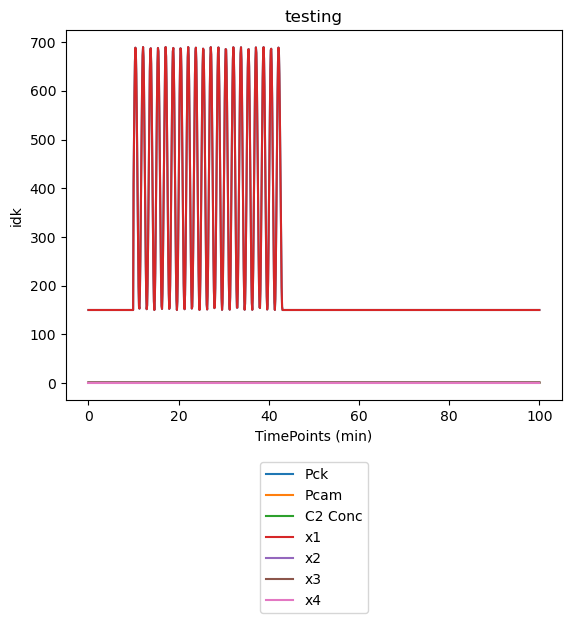

In [806]:
y0 = [0.014,0.0,0.0,0.0]
# c2_list = []
# Pck_list = []
# Pcam_list = []
x1_list=[]
x2_list=[]
x3_list=[]
x4_list=[]

for n in timex10:
    solution2 = coupled_system3(y0,n)
    # Pck_list.append(solution2[0])
    # Pcam_list.append(solution2[1])
    # c2_list.append(solution2[2])
    x1_list.append(solution2[0])
    x2_list.append(solution2[1])
    x3_list.append(solution2[2])
    x4_list.append(solution2[3])

# plt.plot(timex10,Pck_list, label = 'Pck')
# plt.plot(timex10,Pcam_list, label = 'Pcam')
# plt.plot(timex10,c2conc_2_list, label = 'C2 Conc')
plt.plot(timex10,x1_list, label = 'x1')
plt.plot(timex10,x2_list, label = 'x2')
plt.plot(timex10,x3_list, label = 'x3')
plt.plot(timex10,x4_list, label = 'x4')
plt.xlabel('TimePoints (min)')
plt.ylabel('idk')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          ncol=1, fancybox=True)
plt.title("testing")

In [808]:
solution = odeint(func = coupled_system3,y0 = y0,t = timex10)
#huh!
solution_df = pd.DataFrame(solution)
solution_df = solution_df.rename(columns={0:'x1',1:'x2', 2:'x3', 3:'x4'})

/var/folders/d1/t36jr2g51dl5124ky8htph_r0000gq/T/ipykernel_32096/4075834536.py:1: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.



In [809]:
plt.plot(timex10,calcium_dx_df['Pck'], label = 'Pck')
plt.plot(timex10,calcium_dx_df['Pcam'], label = 'Pcam')
plt.plot(timex10,calcium_dx_df['c2_conc'], label = 'C2 Conc')
plt.plot(timex10,solution_df['x1'], label = 'x1')
plt.plot(timex10,solution_df['x2'], label = 'x2')
plt.plot(timex10,solution_df['x3'], label = 'x3')
plt.plot(timex10,solution_df['x4'], label = 'x4')
plt.xlabel('TimePoints (min)')
plt.ylabel('idk')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          ncol=1, fancybox=True)
plt.title("ooh!")

Text(0.5, 1.0, 'ooh!')

/opt/miniconda3/envs/lettuce1/lib/python3.12/site-packages/matplotlib/axes/_base.py:2982: RuntimeWarning:

overflow encountered in scalar subtract



Error in callback <function _draw_all_if_interactive at 0x165cfe3e0> (for post_execute), with arguments args (),kwargs {}:


ValueError: arange: cannot compute length

ValueError: arange: cannot compute length

<Figure size 640x480 with 1 Axes>

im going to adjust the start value of x1,x2,x3,x4 to bring it into a similar ballpark as calcium.

In [ ]:
#Equations 1 - 4
# x1 = [Phos Thr-271 CCaMK]
# x2 = [CaM-bound CCaMK]
# x3 = [Cam-bound Thr-271]
# x4 = [Phos CCaMK]
# probably a mistake x = [Phos Target Molecule]
y0 = [0.014,0,0,0]

solution = odeint(func = coupled_system3,y0 = y0,t = timex10)
solution_df = pd.DataFrame(solution)
solution_df = solution_df.rename(columns={0:'x1',1:'x2', 2:'x3', 3:'x4'})

fig, ax1 = plt.subplots()
ax1.plot(timex10,calcium_dx_df['c2_conc'], label = 'C2 Conc')
ax1.set_ylabel("C2 Concentration nM")

ax2 = ax1.twinx() 
ax2.plot(timex10,calcium_dx_df['Pck'], label = 'Pck')
ax2.plot(timex10,calcium_dx_df['Pcam'], label = 'Pcam')
ax2.plot(timex10,solution_df['x1']*100, label = 'x1')
ax2.plot(timex10,solution_df['x2']*100, label = 'x2')
ax2.plot(timex10,solution_df['x3']*100, label = 'x3')
ax2.plot(timex10,solution_df['x4']*100, label = 'x4')
ax2.set_xlabel('TimePoints (min)')
ax2.set_ylabel('idk')
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          ncol=1, fancybox=True)
plt.title("ooh!")

fig.tight_layout() 

TypeError: coupled_system3() missing 1 required positional argument: 'title'

actually, this makes me wonder what is happening to c2conc, pck, and pcam, since currently i am only plotting them with the calcium_dx_df data. perhaps they're doing something entirely different within the function

In [104]:
import sys

In [105]:
def coupled_system3(y,t,title):
    x1,x2,x3,x4 = y
    c2_conc = c2_conc_eq(150,t)
    Pck = Pck_eq(c2_conc)
    Pcam = Pcam_eq(c2_conc)
    dx1_dt = (Pck*(1-Pck)*(k1*(T-x1-x2-x3)**2)) + (k2*x1*(T-x1-x2-x3)) + (k_pstar_off*(1-Pcam)*(1-Pck)*x3) + (k_p_off*Pcam*Pck*x3) - (k_p_on * Pcam * Pck * (C-x2-x3)*x1) - (k_dp*x1)
    dx2_dt = (k_on * Pcam * Pck *(C-x2-x3)*(T-x1-x2-x3)) - (k_star_off * (1-Pcam)*(1-Pck) * x2) - (k_off * Pcam * Pck * x2) + (k_cdp * x3)
    dx3_dt = (k_p_on * Pcam * Pck * (C-x2-x3) * x1) - (k_pstar_off * (1-Pcam)*(1-Pck)*x3) - (k_p_off * Pcam * Pck * x3) - (k_cdp * x3)
    dx4_dt = k_cy_p * (x2+x3+Pck*ac*(T-x1-x2-x3))*(1-x4) - (k_cy_dp * x4)
    filepath = "/Users/guf24vol/Documents/training/training/ode_cal/" + f"{title}.txt"
    original = sys.stdout
    sys.stdout = open(filepath, "a") #note, need to make a new file eachtime this is ran
    print(f"{c2_conc},{Pck},{Pcam},{t}")
    sys.stdout = original
    return [dx1_dt,dx2_dt,dx3_dt,dx4_dt]

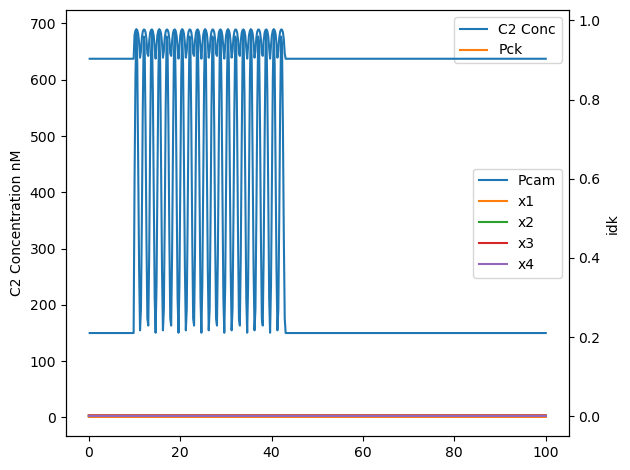

In [109]:
timex10 = time

#Equations 1 - 4
# x1 = [Phos Thr-271 CCaMK]
# x2 = [CaM-bound CCaMK]
# x3 = [Cam-bound Thr-271]
# x4 = [Phos CCaMK]
# probably a mistake x = [Phos Target Molecule]
y0 = [0.014,0,0,0]
x1_list=[]
x2_list=[]
x3_list=[]
x4_list=[]

for n in timex10:
    solution2 = coupled_system3(y0,n,title = "testingfun_cal_etc")
    x1_list.append(solution2[0])
    x2_list.append(solution2[1])
    x3_list.append(solution2[2])
    x4_list.append(solution2[3])

funcal_df = pd.read_csv("ode_cal/testingfun_cal_etc.txt", header=0, names = ["c2_conc", "Pck", "Pcam","Time"])
# in this context, time is acting as to be expected!

fig, ax1 = plt.subplots()
ax1.plot(timex10[1:],funcal_df['c2_conc'], label = 'C2 Conc')
ax1.plot(timex10[1:],funcal_df['Pck'], label = 'Pck')
ax1.set_ylabel("C2 Concentration nM")
plt.legend(loc = "best")

ax2 = ax1.twinx() 
ax2.plot(timex10[1:],funcal_df['Pcam'], label = 'Pcam')
ax2.plot(timex10,x1_list, label = 'x1')
ax2.plot(timex10,x2_list, label = 'x2')
ax2.plot(timex10,x3_list, label = 'x3')
ax2.plot(timex10,x4_list, label = 'x4')
ax2.set_xlabel('TimePoints (min)')
ax2.set_ylabel('idk')
plt.legend(loc='best')
# plt.title("uhhh?")

fig.tight_layout() 

# solution = odeint(func = coupled_system3,y0 = y0,t = timex10,title = "testingfun_cal_etc")
# solution_df = pd.DataFrame(solution)
# solution_df = solution_df.rename(columns={0:'x1',1:'x2', 2:'x3', 3:'x4'})


so, in the above i asked the function to report Time, because the txt file output was longer than the solution df, and longer than timex10, which i didn't expect. question is, why the fuck does the time value act so weirdly in this function?!

In [114]:
solution = odeint(func = coupled_system3,y0 = y0,t = timex10,args = ('odeint_cal_etc',))
#huh!
solution_df = pd.DataFrame(solution)
solution_df = solution_df.rename(columns={0:'x1',1:'x2', 2:'x3', 3:'x4'})

In [115]:
odecal_df = pd.read_csv("ode_cal/odeint_cal_etc.txt", header=0, names = ["c2_conc", "Pck", "Pcam"])

#since time is acting weirdly, and not matching timex10, i'll create a new np linspace of length data, just to visualise it
fu_time = np.linspace(0,100,len(odecal_df))

TypeError: 'str' object is not callable

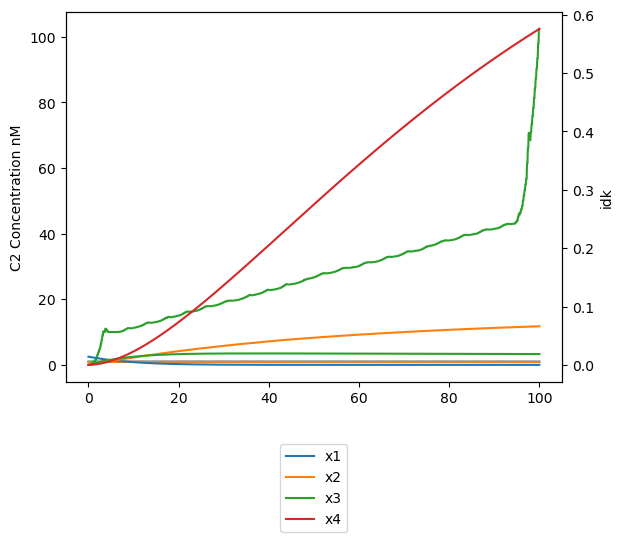

In [113]:
fig, ax1 = plt.subplots()
ax1.plot(fu_time,odecal_df['c2_conc'], label = 'C2 Conc')
ax1.plot(fu_time,odecal_df['Pck'], label = 'Pck')
ax1.plot(fu_time,odecal_df['Pcam'], label = 'Pcam')
ax1.set_ylabel("C2 Concentration nM")

ax2 = ax1.twinx() 
ax2.plot(timex10,solution_df['x1'], label = 'x1')
ax2.plot(timex10,solution_df['x2'], label = 'x2')
ax2.plot(timex10,solution_df['x3'], label = 'x3')
ax2.plot(timex10,solution_df['x4'], label = 'x4')
ax2.set_xlabel('TimePoints (min)')
ax2.set_ylabel('idk')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          ncol=1, fancybox=True)
# plt.title("i've made a postmodern graph")

fig.tight_layout() 

since when derived the sin curve flies off into the distance, i'm going to use the cosine curve, conc_dx() instead, even though that also looks a bit weird!

In [118]:
def coupled_system4(y,t,title):
    x1,x2,x3,x4 = y
    c2_conc = conc_dx(150,t)
    Pck = Pck_eq(c2_conc)
    Pcam = Pcam_eq(c2_conc)
    dx1_dt = (Pck*(1-Pck)*(k1*(T-x1-x2-x3)**2)) + (k2*x1*(T-x1-x2-x3)) + (k_pstar_off*(1-Pcam)*(1-Pck)*x3) + (k_p_off*Pcam*Pck*x3) - (k_p_on * Pcam * Pck * (C-x2-x3)*x1) - (k_dp*x1)
    dx2_dt = (k_on * Pcam * Pck *(C-x2-x3)*(T-x1-x2-x3)) - (k_star_off * (1-Pcam)*(1-Pck) * x2) - (k_off * Pcam * Pck * x2) + (k_cdp * x3)
    dx3_dt = (k_p_on * Pcam * Pck * (C-x2-x3) * x1) - (k_pstar_off * (1-Pcam)*(1-Pck)*x3) - (k_p_off * Pcam * Pck * x3) - (k_cdp * x3)
    dx4_dt = k_cy_p * (x2+x3+Pck*ac*(T-x1-x2-x3))*(1-x4) - (k_cy_dp * x4)
    filepath = "/Users/guf24vol/Documents/training/training/ode_cal/" + f"{title}.txt"
    original = sys.stdout
    sys.stdout = open(filepath, "a") #note, need to make a new file eachtime this is ran
    print(f"{c2_conc},{Pck},{Pcam},{t}")
    sys.stdout = original
    return [dx1_dt,dx2_dt,dx3_dt,dx4_dt]

AttributeError: 'tuple' object has no attribute 'plot'

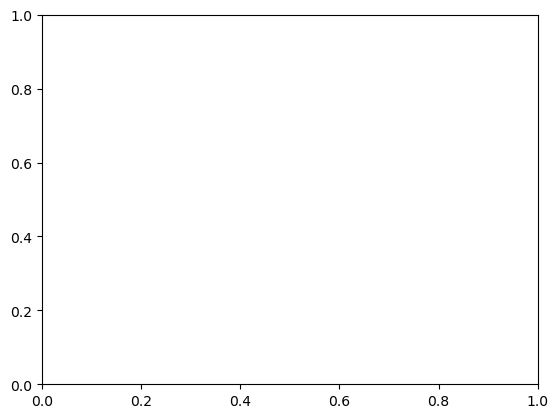

In [122]:
# solution = odeint(func = coupled_system4,y0 = y0,t = timex10,args = ('odeint_cal_etc2',))
# solution_df = pd.DataFrame(solution)
# solution_df = solution_df.rename(columns={0:'x1',1:'x2', 2:'x3', 3:'x4'})

# fig, ax1 = plt.subplots()
# ax1.plot(fu_time,odecal_df['c2_conc'], label = 'C2 Conc')
# ax1.plot(fu_time,odecal_df['Pck'], label = 'Pck')
# ax1.plot(fu_time,odecal_df['Pcam'], label = 'Pcam')
# ax1.set_ylabel("C2 Concentration nM")

ax2 = plt.subplots() #ax1.twinx() 
ax2.plot(timex10,solution_df['x1'], label = 'x1')
ax2.plot(timex10,solution_df['x2'], label = 'x2')
ax2.plot(timex10,solution_df['x3'], label = 'x3')
ax2.plot(timex10,solution_df['x4'], label = 'x4')
ax2.set_xlabel('TimePoints (min)')
ax2.set_ylabel('idk')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          ncol=1, fancybox=True)